# Large Value Fund Prediction Modelling: Random Forest Classifier

This section uses a Random Forest Classifier model to predict the probable direction of prices for the top 4 Large Value ETFs (Dividend ETFs) by fund size (in billions - USD). As mentioned on Notebook 2, those index funds are:<br />

IWD - iShares Russell 1000 Value ETF<br />
SCHD - Schwab U.S. Dividend Equity ETF<br />
VYM - Vanguard High Dividend Yield Index Fund<br />
DGRO - iShares Core Dividend Growth ETF<br />

<br />
The notebook's sections about the Prediction / Machine Learning Model are:<br />
1. Set up libraries, download historical data & visualize data<br />
2. Set up Machine Learning / M.L. target<br />
3. Train our initial model (Random Forest Classifier)<br />
4. Build a backtest system<br />
5. See results from backtest system (2nd round of predictions)<br />
6. Insert extra prediction ratio columns<br />
7. Run predictions (3rd round) using backtest again<br />
8. after adding ratios & modifying prediction function<br />
9. Statistical results - IMPORTANT<br />
10. Conclusion - IMPORTANT<br />

<br />
Morningstar fund definitions:<br /> 
1. Large Growth Funds are defined as those that invest in large-sized companies projected to grow fast. These tend to have high volatility, and high valuations (high price ratios & low dividend yields). These are known for being ‘high risk but high reward’.<br />
2. Large Value Funds are defined as those that invest in large-sized companies that have slow growth and low valuations (low price ratios and high dividend yields).<br />
3. Large Blend Funds are defined as those that invest in a combination of large Value & large Growth. These funds represent the overall U.S. Stock market and invest in across the spectrum of U.S. industries.<br />

# What is a Random Forest?

Random forests or random decision forests is a learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees - therefore the output of multiple decision trees reach a single result. Random decision forests correct for decision trees' habit of overfitting to their training set. In this case, the outcome is the probability that states how likely is for prices to increase tomorrow.

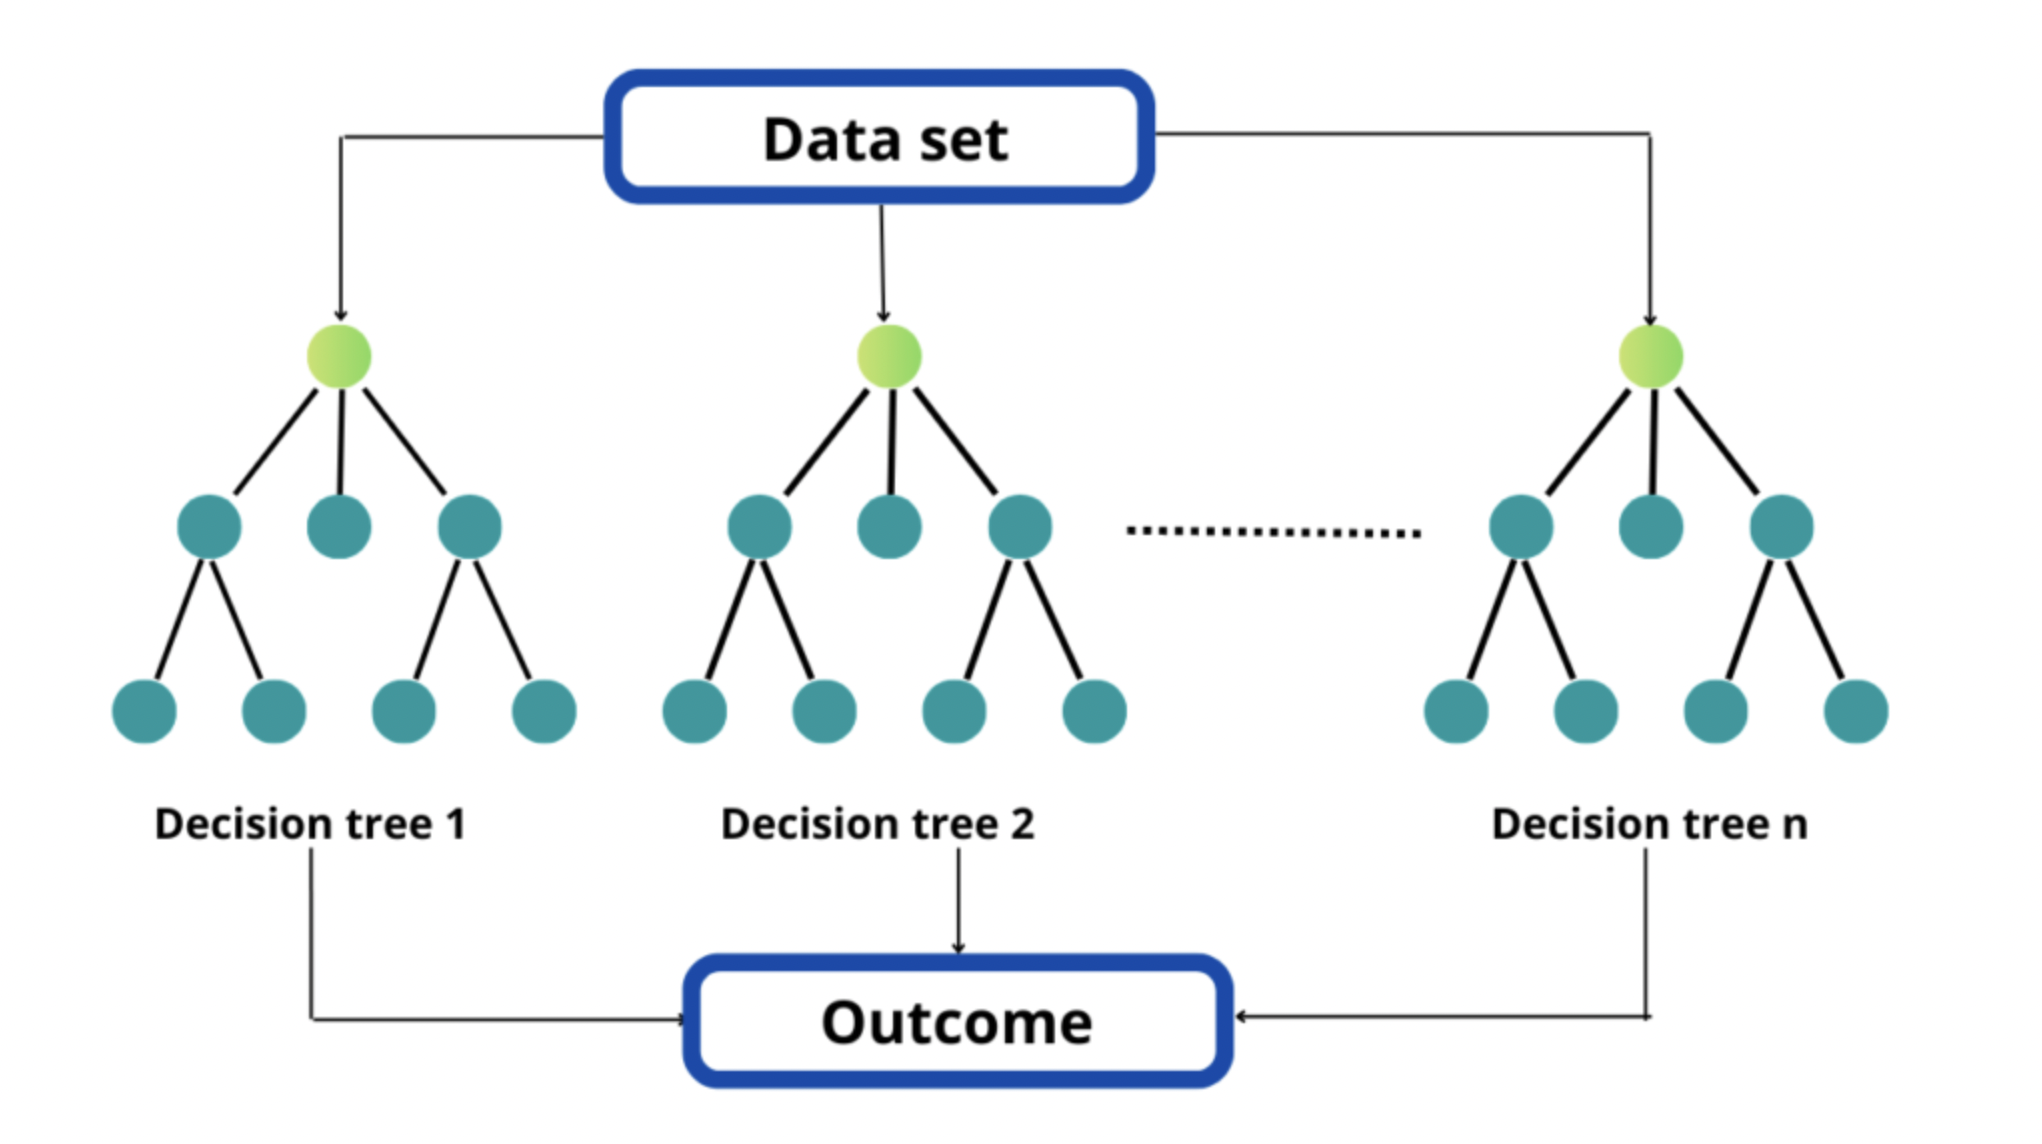

# Step 1 - Import libraries, download historical data & visualize data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [2]:
# Get data; starting dates are the funds' inception dates
iwd = yf.download("IWD", '2000-05-22', '2023-12-30')
schd = yf.download("SCHD", '2011-10-20', '2023-12-30')
vym = yf.download("VYM", '2006-11-10', '2023-12-30')
dgro = yf.download("DGRO", '2014-06-10', '2023-12-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Check index
iwd.index
#schd.index
#vym.index
#dgro.index

DatetimeIndex(['2000-05-26', '2000-05-30', '2000-05-31', '2000-06-01',
               '2000-06-02', '2000-06-05', '2000-06-06', '2000-06-07',
               '2000-06-08', '2000-06-09',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5936, freq=None)

### Make a plot for the 4 Large Value ETFs

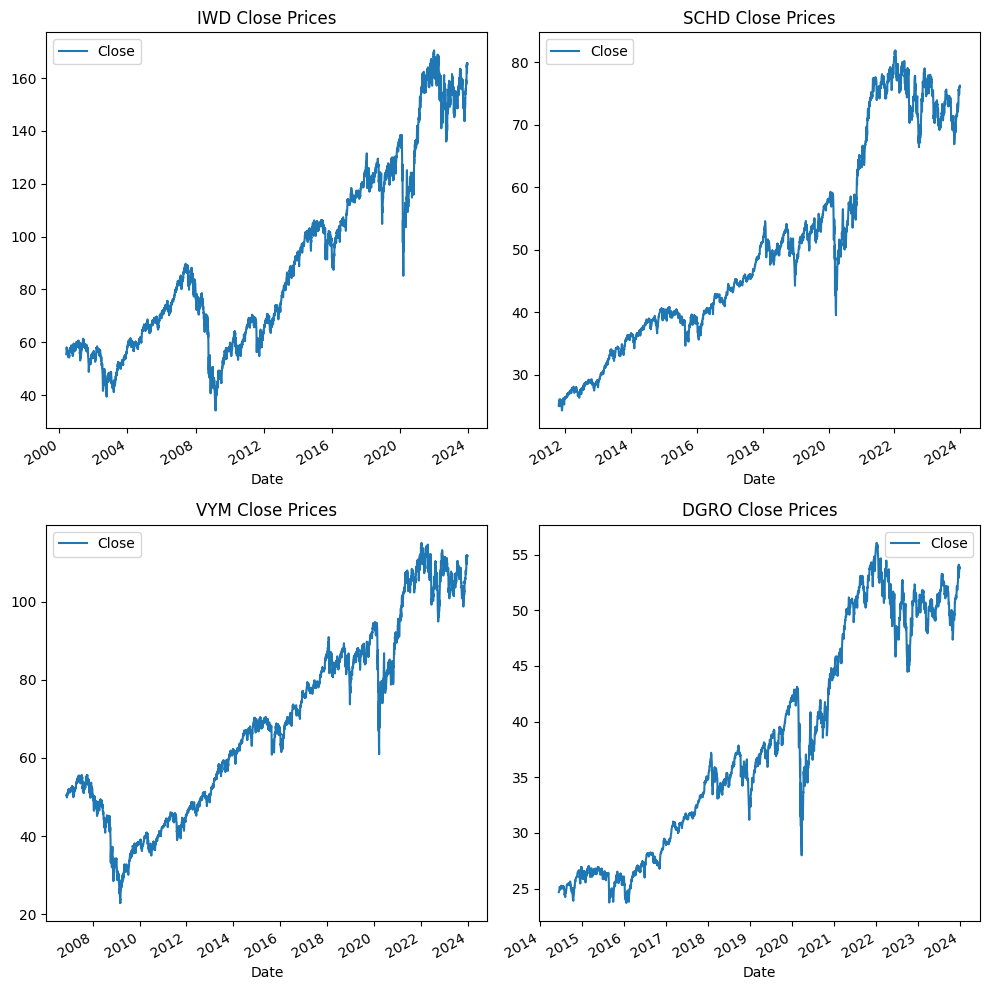

In [4]:
# Plot 4 graphs; define as y functions 
# Initialise the subplot using number of rows and columns (in this case a 4x4 subplot)
figure, axis = plt.subplots(2, 2, figsize=(10,10)) 
iwd.plot.line(y="Close", use_index=True, ax=axis[0,0]).title.set_text('IWD Close Prices')
schd.plot.line(y="Close", use_index=True, ax=axis[0,1]).title.set_text('SCHD Close Prices')
vym.plot.line(y="Close", use_index=True, ax=axis[1,0]).title.set_text('VYM Close Prices')
dgro.plot.line(y="Close", use_index=True, ax=axis[1,1]).title.set_text('DGRO Close Prices')

figure.tight_layout();

In [5]:
# Verify that dataframes look accurate
iwd
#schd
#vym
#dgro

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-26,55.500000,55.734375,55.437500,55.500000,32.566940,9500
2000-05-30,55.890625,56.140625,55.890625,56.140625,32.942860,1200
2000-05-31,56.515625,56.828125,56.515625,56.546875,33.181248,25500
2000-06-01,56.812500,57.328125,56.812500,57.062500,33.483822,15300
2000-06-02,58.375000,58.515625,58.093750,58.093750,34.088936,14200
...,...,...,...,...,...,...
2023-12-22,164.139999,164.949997,163.699997,164.279999,164.279999,2599800
2023-12-26,164.610001,165.679993,164.410004,165.220001,165.220001,2949400
2023-12-27,165.289993,165.720001,164.919998,165.460007,165.460007,2524600


# Step 2 - Machine Learning (M.L.) Target

Our target is the following - will the index fund price go up or down? we are not looking for an absolute or specific future price for a particular date (as that is almost impossible to predict, what we are looking for is directionality (ideally we want prices to go up unless you are buying shares for a fund or stock) or a statistic that points out the odds of prices increasing 'tomorrow'.

In [6]:
# For 'next day' prediction we need to create a column where we shift forward 1 day of close prices 
# By shifting 1 row forward - the last will be N/A as it has nothing to get compared with.
iwd["Tomorrow"] = iwd["Close"].shift(-1)
schd["Tomorrow"] = schd["Close"].shift(-1)
vym["Tomorrow"] = vym["Close"].shift(-1)
dgro["Tomorrow"] = dgro["Close"].shift(-1)

In [7]:
# Display the dataframe with new column 'Tomorrow'
iwd
#schd
#vym
#dgro

,Open,High,Low,Close,Adj Close,Volume,Tomorrow
Date,,,,,,,
2000-05-26,55.500000,55.734375,55.437500,55.500000,32.566940,9500,56.140625
2000-05-30,55.890625,56.140625,55.890625,56.140625,32.942860,1200,56.546875
2000-05-31,56.515625,56.828125,56.515625,56.546875,33.181248,25500,57.062500
2000-06-01,56.812500,57.328125,56.812500,57.062500,33.483822,15300,58.093750
2000-06-02,58.375000,58.515625,58.093750,58.093750,34.088936,14200,57.781250
...,...,...,...,...,...,...,...
2023-12-22,164.139999,164.949997,163.699997,164.279999,164.279999,2599800,165.220001
2023-12-26,164.610001,165.679993,164.410004,165.220001,165.220001,2949400,165.460007
2023-12-27,165.289993,165.720001,164.919998,165.460007,165.460007,2524600,165.699997


In [8]:
# We now create a Target column with boolean output
# Outputs are 1 for 'True - prices increased the day after' & 0 for 'False - prices decreased the day after'
iwd["Target"] = (iwd["Tomorrow"] > iwd["Close"]).astype(int)
schd["Target"] = (schd["Tomorrow"] > schd["Close"]).astype(int)
vym["Target"] = (vym["Tomorrow"] > vym["Close"]).astype(int)
dgro["Target"] = (dgro["Tomorrow"] > dgro["Close"]).astype(int)

### New columns 'Target' & 'Tomorrow' should display

In [9]:
# Display the dataframe with new column 'Target'
iwd
#schd
#vym
#dgro

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,
2000-05-26,55.500000,55.734375,55.437500,55.500000,32.566940,9500,56.140625,1
2000-05-30,55.890625,56.140625,55.890625,56.140625,32.942860,1200,56.546875,1
2000-05-31,56.515625,56.828125,56.515625,56.546875,33.181248,25500,57.062500,1
2000-06-01,56.812500,57.328125,56.812500,57.062500,33.483822,15300,58.093750,1
2000-06-02,58.375000,58.515625,58.093750,58.093750,34.088936,14200,57.781250,0
...,...,...,...,...,...,...,...,...
2023-12-22,164.139999,164.949997,163.699997,164.279999,164.279999,2599800,165.220001,1
2023-12-26,164.610001,165.679993,164.410004,165.220001,165.220001,2949400,165.460007,1
2023-12-27,165.289993,165.720001,164.919998,165.460007,165.460007,2524600,165.699997,1


# Step 3 - Train initial model based on a Random Forest Classifier Algorithm

The random forest classifier is a M.L. algorithm that trains multiple decision trees with randomized parameters, and averages results from those decision trees; therefore, random forests are resistant to overfitting (term that refers to the case when a model gives a high accurate prediction for training data but not new data real world information). Note that the open price column is not linearly correlated with the target column (meaning that if open price is higher, that doesn't mean the target price will be higher).

Notice these dataframes we are training are time series data (prices that change with respect to time). The training set consists of all of the rows except the last 100. Last 100 rows go into the testing set, so that the model learns from the past without knowing anything about the future, otherwise accuracy will be high on the model but inefficient in the real world as it would 'already know about the future'.

In [10]:
# Apply model variable to begin process
# 'n estimators' is the number of individual decision trees we want to train, the higher the n, the better the accuracy (up to a limit)
# 'min sample split' reduces overfitting
# 'random state' seed of '1' allows for running the same model multiple times, and that random numbers that are generated will be in a predictable sequence

iwd_model_1 = RandomForestClassifier(n_estimators = 75, min_samples_split = 75, random_state = 1)
schd_model_1 = RandomForestClassifier(n_estimators = 50, min_samples_split = 50, random_state = 1)
vym_model_1 = RandomForestClassifier(n_estimators = 75, min_samples_split = 75, random_state = 1)
dgro_model_1 = RandomForestClassifier(n_estimators = 50, min_samples_split = 50, random_state = 1)

In [11]:
def ran_basic_model(model, dataframe):
    train = dataframe.iloc[:-100] # We want to train all rows except for last 100
    test = dataframe.iloc[-100:] # We want to test only last 100 rows
    predictors = ["Close", "Volume", "Open", "High", "Low"] # We use absolute numerical data from original cols.
    model.fit(train[predictors], train["Target"]) # Training phase of predictors & boolean based Target column
    
    preds = model.predict(test[predictors]) # Run prediction on testing data - to see if training went well
    preds = pd.Series(preds, index=test.index) # Predictions are stored in a numpy array - turn to Pandas Series
    score = precision_score(test["Target"], preds)
    neg_score = 1 - score
    combined = pd.concat([test["Target"], preds], axis=1)
    combined.plot()
    msg1 = "The probability of price increment for this fund for tomorrow is: " + str(score)
    msg2 = "The probability of price decrement for this fund for tomorrow is: " + str(neg_score)
    print(msg1)
    print(msg2)

### Orange line is the prediction for the last 100 days based off training data for IWD (23 years & 7 months worth of data points), SCHD (12 years & 2 months worth of data points), VYM (17 years & 1 month worth of data points), & DGRO (9 years & 6 months worth of data points).

The probability of price increment for this fund for tomorrow is: 0.47540983606557374
The probability of price decrement for this fund for tomorrow is: 0.5245901639344263


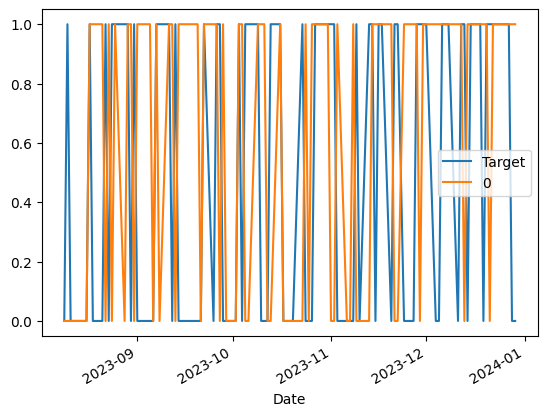

In [12]:
iwd_predictions_1 = ran_basic_model(iwd_model_1, iwd)

The probability of price increment for this fund for tomorrow is: 0.5555555555555556
The probability of price decrement for this fund for tomorrow is: 0.4444444444444444


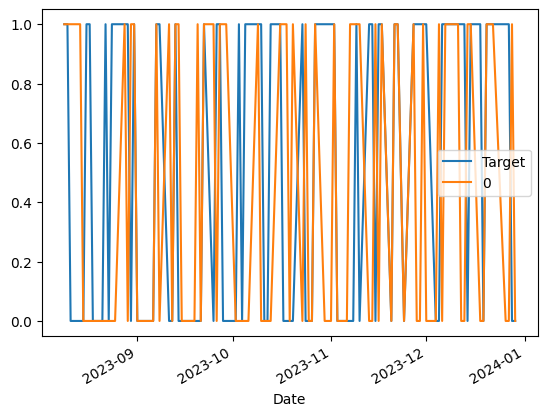

In [13]:
schd_predictions_1 = ran_basic_model(schd_model_1, schd)

The probability of price increment for this fund for tomorrow is: 0.4918032786885246
The probability of price decrement for this fund for tomorrow is: 0.5081967213114754


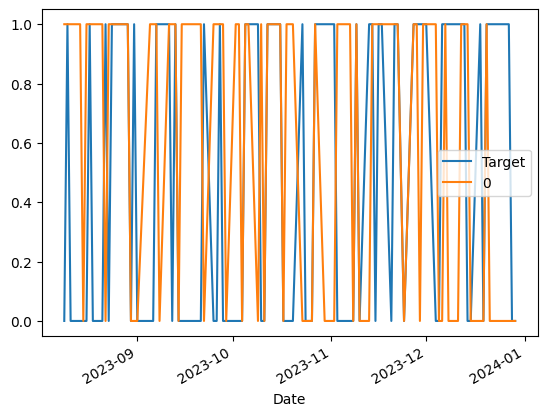

In [14]:
vym_predictions_1 = ran_basic_model(vym_model_1, vym)

The probability of price increment for this fund for tomorrow is: 0.4927536231884058
The probability of price decrement for this fund for tomorrow is: 0.5072463768115942


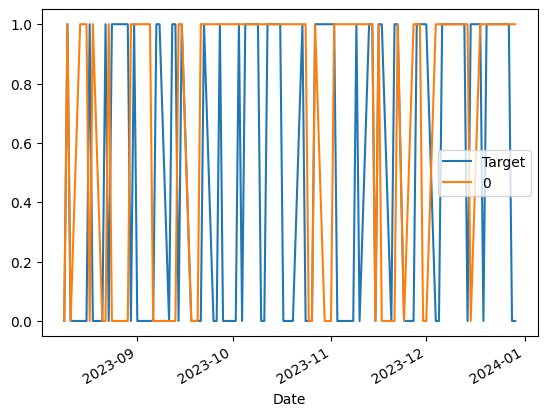

In [15]:
dgro_predictions_1 = ran_basic_model(dgro_model_1, dgro)

# Step 4 - Building a backtest system

The goal is to compare the previous model with the backtest system. We first need to create a predictions function and then a backtest function that for every 10-year period, we'll train 1 year, then the next one, and so forth. Note that every trading year has 250 days, therefore 10 years is 2500 days.

In [16]:
# 1st step - create generic prediction function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [17]:
# 2nd step - backtest function uses previous prediction function
def backtest(dataframe, model, predictors, start=2500, step=250):
    all_predictions = [] 
    # list of dataframes, where we loop across our data year by year (except 1st 10 years) 
    # each data frame is the prediction of a single year
    for i in range(start, dataframe.shape[0], step):
        train = dataframe.iloc[0:i].copy() # training set includes all years prior to current
        test = dataframe.iloc[i:(i+step)].copy() #testing set is current year
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [23]:
# 2nd step - backtest function uses previous prediction function
# Customized code for DGRO - as the original backtest needs at least 10 years of data, DGRO only has 9
def dgro_backtest(dataframe, model, predictors, start=2000, step=250):
    all_predictions = [] 
    # list of dataframes, where we loop across our data year by year (except 1st 10 years) 
    # each data frame is the prediction of a single year
    for i in range(start, dataframe.shape[0], step):
        train = dataframe.iloc[0:i].copy() # training set includes all years prior to current
        test = dataframe.iloc[i:(i+step)].copy() #testing set is current year
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

# Step 5 - See results from backtest system (2nd round of predictions)

In [18]:
# Set predictors variable - array
predictors = ["Close", "Volume", "Open", "High", "Low"]

In [19]:
# Call backtest function for IWD
iwd_predictions_2 = backtest(iwd, iwd_model_1, predictors)

In [20]:
# Call backtest function for SCHD
schd_predictions_2 = backtest(schd, schd_model_1, predictors)

In [21]:
# Call backtest function for VYM
vym_predictions_2 = backtest(vym, vym_model_1, predictors)

In [24]:
# Call backtest function for DGRO
dgro_predictions_2 = dgro_backtest(dgro, dgro_model_1, predictors)

### '0' represents prediction when the prices goes down, '1' when the prices goes up

In [25]:
# We are counting IWD prediction values
iwd_predictions_2["Predictions"].value_counts()

1    2023
0    1413
Name: Predictions, dtype: int64

In [26]:
# We are counting SCHD prediction values
schd_predictions_2["Predictions"].value_counts()

0    286
1    282
Name: Predictions, dtype: int64

In [27]:
# We are counting VYM prediction values
vym_predictions_2["Predictions"].value_counts()

0    991
1    817
Name: Predictions, dtype: int64

In [28]:
# We are counting DGRO prediction values
dgro_predictions_2["Predictions"].value_counts()

1    264
0    141
Name: Predictions, dtype: int64

### This percentage means we were x% accurate out of the entire training set. So when we say the fund's value goes 'up', it went up x% of the time

In [29]:
# IWD percentage
precision_score(iwd_predictions_2["Target"], iwd_predictions_2["Predictions"])

0.5308947108255067

In [30]:
# SCHD percentage
precision_score(schd_predictions_2["Target"], schd_predictions_2["Predictions"])

0.524822695035461

In [31]:
# VYM percentage
precision_score(vym_predictions_2["Target"], vym_predictions_2["Predictions"])

0.5397796817625459

In [32]:
# DGRO percentage
precision_score(dgro_predictions_2["Target"], dgro_predictions_2["Predictions"])

0.5113636363636364

### Is the previous result good? The benchmark is based on how many times we predicted it would go up divided by total number of rows

In [33]:
# Benchmark for IWD
iwd_predictions_2["Target"].value_counts() / iwd_predictions_2.shape[0]

1    0.534342
0    0.465658
Name: Target, dtype: float64

In [34]:
# Benchmark for SCHD
schd_predictions_2["Target"].value_counts() / schd_predictions_2.shape[0]

1    0.521127
0    0.478873
Name: Target, dtype: float64

In [35]:
# Benchmark for VYM
vym_predictions_2["Target"].value_counts() / vym_predictions_2.shape[0]

1    0.535951
0    0.464049
Name: Target, dtype: float64

In [36]:
# Benchmark for DGRO
dgro_predictions_2["Target"].value_counts() / dgro_predictions_2.shape[0]

1    0.51358
0    0.48642
Name: Target, dtype: float64

# Step 6 - Insert extra prediction ratio columns

In [37]:
# re-write predict function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] #this returns a probability that row will be 0 or 1
    preds[preds >=.6] = 1 #change threshold to 60% - if greater than or equal to .6 then return 1
    preds[preds <.6] = 0 #change threshold to 60% - if less than .6 then return 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [38]:
# Add ratio columns to dataframes or datasets
# 'horizons' refer to last year, last 3 month, last 5 days, last 2 days
horizons = [2, 5, 60, 250] 
schd_new_predictors = []
vym_new_predictors = []
dgro_new_predictors = []

schd_model_init = RandomForestClassifier(n_estimators=100, min_samples_split=25, random_state=1)
vym_model_init = RandomForestClassifier(n_estimators=100, min_samples_split=25, random_state=1)
dgro_model_init = RandomForestClassifier(n_estimators=100, min_samples_split=25, random_state=1)

for horizon in horizons:
    schd_rolling_averages = schd.rolling(horizon).mean()
    vym_rolling_averages = vym.rolling(horizon).mean()
    dgro_rolling_averages = dgro.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    schd[ratio_column] = schd["Close"] / schd_rolling_averages["Close"]
    vym[ratio_column] = vym["Close"] / vym_rolling_averages["Close"]
    dgro[ratio_column] = dgro["Close"] / dgro_rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    schd[trend_column] = schd.shift(1).rolling(horizon).sum()["Target"]
    vym[trend_column] = vym.shift(1).rolling(horizon).sum()["Target"]
    dgro[trend_column] = dgro.shift(1).rolling(horizon).sum()["Target"]

    schd_new_predictors += [ratio_column, trend_column]
    vym_new_predictors += [ratio_column, trend_column]
    dgro_new_predictors += [ratio_column, trend_column]

In [39]:
# 'v_horizons' refer to the last 4 years, last year, last 3 month, last 5 days, last 2 days - for voo
# This block code was designed for VOO's prediction as it contains less data - doing a 4-yr loop leads to an error
v_horizons = [2, 5, 60, 250, 1000] 
iwd_new_predictors = []

iwd_model_init = RandomForestClassifier(n_estimators=150, min_samples_split=38, random_state=1)

for horizon in v_horizons:
    iwd_rolling_averages = iwd.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    iwd[ratio_column] = iwd["Close"] / iwd_rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    iwd[trend_column] = iwd.shift(1).rolling(horizon).sum()["Target"]

    iwd_new_predictors += [ratio_column, trend_column]

In [40]:
iwd = iwd.dropna(subset = iwd.columns[iwd.columns != "Tomorrow"])
schd = schd.dropna(subset = schd.columns[schd.columns != "Tomorrow"])
vym = vym.dropna(subset = vym.columns[vym.columns != "Tomorrow"])
dgro = dgro.dropna(subset = dgro.columns[dgro.columns != "Tomorrow"])

In [44]:
# Verify new dataframes have no errors
#iwd #4936 rows
#schd #2818 rows
#vym #4058 rows
dgro #2155 rows

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,,
2015-06-10,26.379999,26.577999,26.379999,26.549999,21.668745,23900,26.639999,1,1.005301,2.0,1.006215,2.0,0.999026,29.0,1.026116,124.0
2015-06-11,26.600000,26.670000,26.580000,26.639999,21.742197,18000,26.440001,0,1.001692,2.0,1.008327,3.0,1.002292,30.0,1.029294,124.0
2015-06-12,26.600000,26.600000,26.420000,26.440001,21.578972,45900,26.290001,0,0.996232,1.0,1.000378,3.0,0.994942,29.0,1.021311,123.0
2015-06-15,26.370001,26.370001,26.163000,26.290001,21.456545,36700,26.450001,1,0.997155,0.0,0.994402,3.0,0.989483,29.0,1.015297,122.0
2015-06-16,26.190001,26.454000,26.190001,26.450001,21.587133,21900,26.510000,1,1.003034,1.0,0.999093,3.0,0.995742,29.0,1.021263,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,53.439999,53.750000,53.360001,53.529999,53.529999,1995500,53.790001,1,1.001684,2.0,0.999851,4.0,1.060462,34.0,1.056043,132.0
2023-12-26,53.570000,53.889999,53.530998,53.790001,53.790001,1447500,53.869999,1,1.002423,2.0,1.004669,4.0,1.064116,35.0,1.060861,132.0
2023-12-27,53.770000,53.889999,53.660000,53.869999,53.869999,2117800,53.900002,1,1.000743,2.0,1.007029,4.0,1.064039,36.0,1.062079,133.0


# Step 7 - Run predictions (3rd round) after adding ratios & modifying prediction function

In [45]:
# Apply backtest function for IWD
iwd_predictions_3 = backtest(iwd, iwd_model_init, iwd_new_predictors)

In [46]:
# Apply backtest function for SCHD
schd_predictions_3 = backtest(schd, schd_model_init, schd_new_predictors)

In [47]:
# Apply backtest function for VYM
vym_predictions_3 = backtest(vym, vym_model_init, vym_new_predictors)

In [49]:
# Apply backtest function for DGRO
dgro_predictions_3 = dgro_backtest(dgro, dgro_model_init, dgro_new_predictors)

### Prediction percentages - IWD (Precision Score & Benchmark %)

In [50]:
iwd_predictions_3["Predictions"].value_counts()

0.0    2061
1.0     375
Name: Predictions, dtype: int64

In [51]:
# Precision score %
precision_score(iwd_predictions_3["Target"], iwd_predictions_3["Predictions"])

0.512

In [52]:
# Benchmark %
iwd_predictions_3["Target"].value_counts() / iwd_predictions_3.shape[0]

1    0.530788
0    0.469212
Name: Target, dtype: float64

### Prediction percentages - SCHD (Precision Score & Benchmark %)

In [53]:
schd_predictions_3["Predictions"].value_counts()

0.0    211
1.0    107
Name: Predictions, dtype: int64

In [54]:
# Precision score %
precision_score(schd_predictions_3["Target"], schd_predictions_3["Predictions"])

0.5607476635514018

In [55]:
# Benchmark %
schd_predictions_3["Target"].value_counts() / schd_predictions_3.shape[0]

1    0.518868
0    0.481132
Name: Target, dtype: float64

### Prediction percentages - VYM (Precision Score & Benchmark %)

In [56]:
vym_predictions_3["Predictions"].value_counts()

0.0    1286
1.0     272
Name: Predictions, dtype: int64

In [57]:
# Precision score %
precision_score(vym_predictions_3["Target"], vym_predictions_3["Predictions"])

0.5257352941176471

In [58]:
# Benchmark %
vym_predictions_3["Target"].value_counts() / vym_predictions_3.shape[0]

1    0.535302
0    0.464698
Name: Target, dtype: float64

### Prediction percentages - DGRO (Precision Score & Benchmark %)

In [59]:
dgro_predictions_3["Predictions"].value_counts()

0.0    115
1.0     40
Name: Predictions, dtype: int64

In [60]:
# Precision score %
precision_score(dgro_predictions_3["Target"], dgro_predictions_3["Predictions"])

0.5

In [61]:
# Benchmark %
dgro_predictions_3["Target"].value_counts() / dgro_predictions_3.shape[0]

1    0.516129
0    0.483871
Name: Target, dtype: float64

# Step 9 - Results

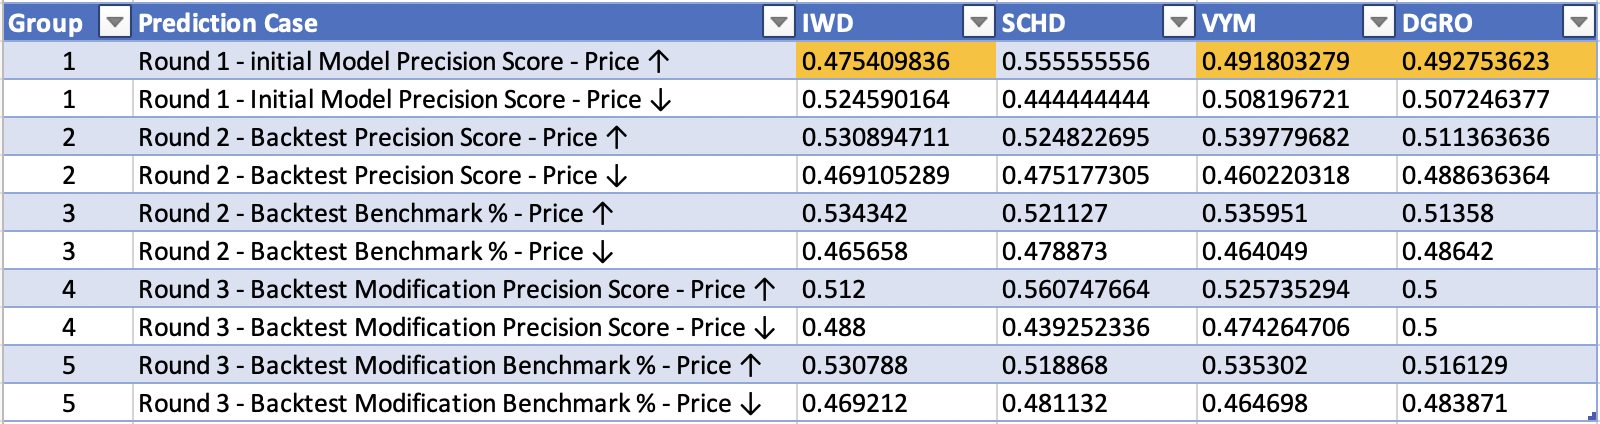

# Step 10 - Conclusion

The random forest decision classifier / machine learning model was trained efficiently as it accurately predicted the odds of share price (from any of the top 4 large value funds - IWD, SCHD, VYM, DGRO) increment in the future or 'tomorrow'. It is reasonable to have a probability ranging between 50% & 60%, as realistically nobody can predict future prices for certain but we are aware (as seen in the financial analysis' Moving Averages graphs - Jupyter Notebooks 1 through 3) that Index Funds tend to increase in value with respect to time despite economic downturns or outlying events (such COVID Pandemic). The highlighted cells (orange) represent the percentages that were off - orange being slightly inaccurate. The reason why precision scores (for tomorrow's price increment) for round 1 were off was due that our training model did not made it through the 50% threshold, except for SCHD which looks accurate. Note that higher inaccuracy is expected on the 1st round, remember that the backtest system was improved after round 1.